# Lottery Ticket Hypothesis - LeNet-300-100 on MNIST

This notebook implements the Lottery Ticket Hypothesis experiment with:
- **Model**: LeNet-300-100 (Fully connected: 784→300→100→10)
- **Dataset**: MNIST
- **Optimizer**: Adam (lr=1.2e-3)
- **Batch Size**: 60
- **Initialization**: Gaussian Glorot (Xavier)
- **Pruning Strategy**: Unstructured, layer-wise magnitude pruning
- **Pruning Rates**: 20% for hidden layers, 10% for output layer
- **Total Iterations**: 100

## Import Required Libraries

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import sys
import os

# Add parent directory to path
sys.path.append(os.path.abspath('../src'))
from pruning import prune_by_percent, create_initial_masks, get_sparsity, get_overall_sparsity
from train import train_epoch, evaluate, train_iterations

import matplotlib.pyplot as plt
from tqdm import tqdm

## Define LeNet-300-100 Model

In [10]:
class LeNet300100(nn.Module):
    """LeNet-300-100: Fully connected network with 300 and 100 hidden units"""
    
    def __init__(self):
        super(LeNet300100, self).__init__()
        # 784 (28x28) -> 300 -> 100 -> 10
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)
        
        # Initialize with Gaussian Glorot (Xavier)
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize weights with Xavier/Glorot normal initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Flatten input
        x = x.view(x.size(0), -1)
        # Hidden layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # Output layer (no activation, use with CrossEntropyLoss)
        x = self.fc3(x)
        return x
    
    def apply_mask(self, masks):
        """Apply pruning masks to the model weights"""
        with torch.no_grad():
            self.fc1.weight.data *= torch.from_numpy(masks['fc1.weight']).float()
            self.fc2.weight.data *= torch.from_numpy(masks['fc2.weight']).float()
            self.fc3.weight.data *= torch.from_numpy(masks['fc3.weight']).float()
    
    def get_weights_as_dict(self):
        """Get model weights as numpy dictionary"""
        return {
            'fc1.weight': self.fc1.weight.data.cpu().numpy(),
            'fc2.weight': self.fc2.weight.data.cpu().numpy(),
            'fc3.weight': self.fc3.weight.data.cpu().numpy()
        }
    
    def set_weights_from_dict(self, weights):
        """Set model weights from numpy dictionary"""
        with torch.no_grad():
            self.fc1.weight.data = torch.from_numpy(weights['fc1.weight']).float()
            self.fc2.weight.data = torch.from_numpy(weights['fc2.weight']).float()
            self.fc3.weight.data = torch.from_numpy(weights['fc3.weight']).float()

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = LeNet300100().to(device)
print(f"\nModel architecture:\n{model}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

Using device: cpu

Model architecture:
LeNet300100(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

Total parameters: 266,610


## Load MNIST Dataset

In [11]:
# MNIST dataset transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders with batch size 60
train_loader = DataLoader(
    train_dataset,
    batch_size=60,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1000,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training samples: 60000
Test samples: 10000
Training batches: 1000
Test batches: 10


## Configure Training and Pruning Parameters

In [12]:
# Configuration
config = {
    # Training parameters
    'learning_rate': 1.2e-3,
    'batch_size': 60,
    'total_iterations': 1000,
    
    # Pruning parameters
    'prune_percents': {
        'fc1.weight': 0.20,  #`` 20% for first hidden layer
        'fc2.weight': 0.20,  # 20% for second hidden layer
        'fc3.weight': 0.10,  # 10% for output layer
    },
    
    # Number of pruning iterations
    'num_pruning_iterations': 20,  # Will prune iteratively
    
    # Calculate training iterations per pruning round
    'iterations_per_round': None  # Will calculate below
}

# Calculate iterations per pruning round
config['iterations_per_round'] = config['total_iterations'] // config['num_pruning_iterations']

print("="*60)
print("CONFIGURATION")
print("="*60)
print(f"\nOptimizer: Adam")
print(f"Learning Rate: {config['learning_rate']}")
print(f"Batch Size: {config['batch_size']}")
print(f"Initialization: Gaussian Glorot (Xavier)")
print(f"\nPruning Strategy: Unstructured, layer-wise magnitude pruning")
print(f"Pruning Rate - Hidden Layers: {config['prune_percents']['fc1.weight']*100}%")
print(f"Pruning Rate - Output Layer: {config['prune_percents']['fc3.weight']*100}%")
print(f"\nTotal Training Iterations: {config['total_iterations']:,}")
print(f"Number of Pruning Rounds: {config['num_pruning_iterations']}")
print(f"Training Iterations per Round: {config['iterations_per_round']:,}")
print(f"\nResetting: Weights reset to initial values (θ₀)")
print("="*60)

CONFIGURATION

Optimizer: Adam
Learning Rate: 0.0012
Batch Size: 60
Initialization: Gaussian Glorot (Xavier)

Pruning Strategy: Unstructured, layer-wise magnitude pruning
Pruning Rate - Hidden Layers: 20.0%
Pruning Rate - Output Layer: 10.0%

Total Training Iterations: 1,000
Number of Pruning Rounds: 20
Training Iterations per Round: 50

Resetting: Weights reset to initial values (θ₀)


## Training and Evaluation Functions

In [13]:
# Training functions are imported from src/train.py
# Available functions:
#   - train_epoch(model, train_loader, criterion, optimizer, device, masks, apply_mask_fn)
#   - evaluate(model, test_loader, criterion, device)
#   - train_iterations(model, train_loader, test_loader, criterion, optimizer, 
#                      num_iterations, device, masks, eval_freq, apply_mask_fn, verbose)

print("Training functions imported from src/train.py")
print("  - train_epoch: Train for one epoch")
print("  - evaluate: Evaluate model on test set")  
print("  - train_iterations: Train for N iterations")

Training functions imported from src/train.py
  - train_epoch: Train for one epoch
  - evaluate: Evaluate model on test set
  - train_iterations: Train for N iterations


## Initialize Model and Save Initial Weights (θ₀)

In [14]:
# Reinitialize model to get fresh weights
model = LeNet300100().to(device)

# Save initial weights (θ₀) - these will be used for rewinding
initial_weights = model.get_weights_as_dict()
print("Initial weights (θ₀) saved for lottery ticket rewinding.")

# Create initial masks (all ones - no pruning yet)
masks = create_initial_masks(initial_weights)
print(f"\nInitial masks created:")
for layer, mask in masks.items():
    print(f"  {layer}: shape {mask.shape}, sparsity: 0.00%")

# Setup loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

print(f"\nOptimizer: Adam(lr={config['learning_rate']})")
print("Model ready for Iterative Magnitude Pruning (IMP)!")

Initial weights (θ₀) saved for lottery ticket rewinding.

Initial masks created:
  fc1.weight: shape (300, 784), sparsity: 0.00%
  fc2.weight: shape (100, 300), sparsity: 0.00%
  fc3.weight: shape (10, 100), sparsity: 0.00%

Optimizer: Adam(lr=0.0012)
Model ready for Iterative Magnitude Pruning (IMP)!


## Iterative Magnitude Pruning (IMP) Loop

In [15]:
# Storage for results across pruning iterations
results = {
    'pruning_iteration': [],
    'overall_sparsity': [],
    'layer_sparsity': [],
    'test_accuracy': [],
    'training_history': []
}

print("="*70)
print("STARTING ITERATIVE MAGNITUDE PRUNING (IMP)")
print("="*70)

for pruning_iter in range(config['num_pruning_iterations']):
    print(f"\n{'='*70}")
    print(f"PRUNING ITERATION {pruning_iter + 1}/{config['num_pruning_iterations']}")
    print(f"{'='*70}")
    
    # Calculate current sparsity
    overall_sparsity = get_overall_sparsity(masks)
    layer_sparsity = get_sparsity(masks)
    
    print(f"\nCurrent Network Sparsity:")
    print(f"  Overall: {overall_sparsity*100:.2f}%")
    for layer, sparsity in layer_sparsity.items():
        remaining = (1 - sparsity) * 100
        print(f"  {layer}: {sparsity*100:.2f}% pruned ({remaining:.2f}% remaining)")
    
    # Reset model to initial weights (θ₀) with current mask
    model.set_weights_from_dict(initial_weights)
    model.apply_mask(masks)
    print(f"\n✓ Weights reset to initial values (θ₀) with pruning mask applied")
    
    # Reinitialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Train for specified iterations
    print(f"\nTraining for {config['iterations_per_round']:,} iterations...")
    training_history = train_iterations(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_iterations=config['iterations_per_round'],
        device=device,
        masks=masks,
        eval_freq=500
    )
    
    # Get final test accuracy
    final_test_acc = training_history['final_test_acc']
    print(f"\n✓ Training complete. Final test accuracy: {final_test_acc:.2f}%")
    
    # Store results
    results['pruning_iteration'].append(pruning_iter)
    results['overall_sparsity'].append(overall_sparsity)
    results['layer_sparsity'].append(layer_sparsity.copy())
    results['test_accuracy'].append(final_test_acc)
    results['training_history'].append(training_history)
    
    # Prune for next iteration (if not the last iteration)
    if pruning_iter < config['num_pruning_iterations'] - 1:
        print(f"\nPruning {config['prune_percents']['fc1.weight']*100:.0f}% of remaining weights in hidden layers...")
        print(f"Pruning {config['prune_percents']['fc3.weight']*100:.0f}% of remaining weights in output layer...")
        
        # Get current weights
        current_weights = model.get_weights_as_dict()
        
        # Apply magnitude-based pruning using the pruning function from src/pruning.py
        masks = prune_by_percent(
            percents=config['prune_percents'],
            masks=masks,
            final_weights=current_weights
        )
        print("✓ Pruning complete. Updated masks for next iteration.")

print(f"\n{'='*70}")
print("ITERATIVE MAGNITUDE PRUNING COMPLETE!")
print(f"{'='*70}")
print(f"\nFinal Network Statistics:")
print(f"  Total pruning iterations: {config['num_pruning_iterations']}")
print(f"  Final overall sparsity: {results['overall_sparsity'][-1]*100:.2f}%")
print(f"  Final test accuracy: {results['test_accuracy'][-1]:.2f}%")
print(f"  Best test accuracy: {max(results['test_accuracy']):.2f}%")

STARTING ITERATIVE MAGNITUDE PRUNING (IMP)

PRUNING ITERATION 1/20

Current Network Sparsity:
  Overall: 0.00%
  fc1.weight: 0.00% pruned (100.00% remaining)
  fc2.weight: 0.00% pruned (100.00% remaining)
  fc3.weight: 0.00% pruned (100.00% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training:   0%|          | 0/50 [00:00<?, ?it/s]/home/kay/Documents/lth/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training: 100%|██████████| 50/50 [00:01<00:00, 37.94it/s, train_acc=13.33%, test_acc=32.93%]



✓ Training complete. Final test accuracy: 88.59%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 2/20

Current Network Sparsity:
  Overall: 19.96%
  fc1.weight: 20.00% pruned (80.00% remaining)
  fc2.weight: 20.00% pruned (80.00% remaining)
  fc3.weight: 10.00% pruned (90.00% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 43.05it/s, train_acc=88.33%, test_acc=86.68%]



✓ Training complete. Final test accuracy: 90.58%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 3/20

Current Network Sparsity:
  Overall: 35.94%
  fc1.weight: 36.00% pruned (64.00% remaining)
  fc2.weight: 36.00% pruned (64.00% remaining)
  fc3.weight: 19.00% pruned (81.00% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 46.37it/s, train_acc=91.67%, test_acc=91.94%]



✓ Training complete. Final test accuracy: 91.51%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 4/20

Current Network Sparsity:
  Overall: 48.72%
  fc1.weight: 48.80% pruned (51.20% remaining)
  fc2.weight: 48.80% pruned (51.20% remaining)
  fc3.weight: 27.10% pruned (72.90% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 42.90it/s, train_acc=91.67%, test_acc=91.56%]



✓ Training complete. Final test accuracy: 93.57%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 5/20

Current Network Sparsity:
  Overall: 58.95%
  fc1.weight: 59.04% pruned (40.96% remaining)
  fc2.weight: 59.04% pruned (40.96% remaining)
  fc3.weight: 34.40% pruned (65.60% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 47.96it/s, train_acc=90.00%, test_acc=90.43%]



✓ Training complete. Final test accuracy: 94.42%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 6/20

Current Network Sparsity:
  Overall: 67.13%
  fc1.weight: 67.23% pruned (32.77% remaining)
  fc2.weight: 67.23% pruned (32.77% remaining)
  fc3.weight: 41.00% pruned (59.00% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 47.82it/s, train_acc=90.00%, test_acc=90.63%]



✓ Training complete. Final test accuracy: 94.98%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 7/20

Current Network Sparsity:
  Overall: 73.68%
  fc1.weight: 73.79% pruned (26.21% remaining)
  fc2.weight: 73.79% pruned (26.21% remaining)
  fc3.weight: 46.90% pruned (53.10% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 41.22it/s, train_acc=85.00%, test_acc=90.29%]



✓ Training complete. Final test accuracy: 94.77%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 8/20

Current Network Sparsity:
  Overall: 78.93%
  fc1.weight: 79.03% pruned (20.97% remaining)
  fc2.weight: 79.03% pruned (20.97% remaining)
  fc3.weight: 52.20% pruned (47.80% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 39.00it/s, train_acc=80.00%, test_acc=79.58%]



✓ Training complete. Final test accuracy: 95.21%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 9/20

Current Network Sparsity:
  Overall: 83.12%
  fc1.weight: 83.22% pruned (16.78% remaining)
  fc2.weight: 83.22% pruned (16.78% remaining)
  fc3.weight: 57.00% pruned (43.00% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 42.05it/s, train_acc=78.33%, test_acc=82.73%]



✓ Training complete. Final test accuracy: 95.22%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 10/20

Current Network Sparsity:
  Overall: 86.48%
  fc1.weight: 86.58% pruned (13.42% remaining)
  fc2.weight: 86.58% pruned (13.42% remaining)
  fc3.weight: 61.30% pruned (38.70% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 44.11it/s, train_acc=76.67%, test_acc=81.83%]



✓ Training complete. Final test accuracy: 95.02%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 11/20

Current Network Sparsity:
  Overall: 89.17%
  fc1.weight: 89.26% pruned (10.74% remaining)
  fc2.weight: 89.26% pruned (10.74% remaining)
  fc3.weight: 65.20% pruned (34.80% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 46.60it/s, train_acc=81.67%, test_acc=82.78%]



✓ Training complete. Final test accuracy: 94.30%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 12/20

Current Network Sparsity:
  Overall: 91.32%
  fc1.weight: 91.41% pruned (8.59% remaining)
  fc2.weight: 91.41% pruned (8.59% remaining)
  fc3.weight: 68.70% pruned (31.30% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 43.73it/s, train_acc=76.67%, test_acc=76.69%]



✓ Training complete. Final test accuracy: 94.87%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 13/20

Current Network Sparsity:
  Overall: 93.05%
  fc1.weight: 93.13% pruned (6.87% remaining)
  fc2.weight: 93.13% pruned (6.87% remaining)
  fc3.weight: 71.80% pruned (28.20% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 41.44it/s, train_acc=76.67%, test_acc=73.91%]



✓ Training complete. Final test accuracy: 94.54%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 14/20

Current Network Sparsity:
  Overall: 94.43%
  fc1.weight: 94.50% pruned (5.50% remaining)
  fc2.weight: 94.50% pruned (5.50% remaining)
  fc3.weight: 74.60% pruned (25.40% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 47.25it/s, train_acc=50.00%, test_acc=63.95%]



✓ Training complete. Final test accuracy: 94.73%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 15/20

Current Network Sparsity:
  Overall: 95.53%
  fc1.weight: 95.60% pruned (4.40% remaining)
  fc2.weight: 95.60% pruned (4.40% remaining)
  fc3.weight: 77.10% pruned (22.90% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 39.95it/s, train_acc=78.33%, test_acc=77.79%]



✓ Training complete. Final test accuracy: 94.11%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 16/20

Current Network Sparsity:
  Overall: 96.42%
  fc1.weight: 96.48% pruned (3.52% remaining)
  fc2.weight: 96.48% pruned (3.52% remaining)
  fc3.weight: 79.40% pruned (20.60% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 44.66it/s, train_acc=66.67%, test_acc=75.54%]



✓ Training complete. Final test accuracy: 93.87%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 17/20

Current Network Sparsity:
  Overall: 97.13%
  fc1.weight: 97.19% pruned (2.81% remaining)
  fc2.weight: 97.18% pruned (2.82% remaining)
  fc3.weight: 81.50% pruned (18.50% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 44.19it/s, train_acc=81.67%, test_acc=79.46%]



✓ Training complete. Final test accuracy: 93.31%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 18/20

Current Network Sparsity:
  Overall: 97.69%
  fc1.weight: 97.75% pruned (2.25% remaining)
  fc2.weight: 97.75% pruned (2.25% remaining)
  fc3.weight: 83.30% pruned (16.70% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 46.53it/s, train_acc=85.00%, test_acc=80.54%]



✓ Training complete. Final test accuracy: 92.41%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 19/20

Current Network Sparsity:
  Overall: 98.15%
  fc1.weight: 98.20% pruned (1.80% remaining)
  fc2.weight: 98.20% pruned (1.80% remaining)
  fc3.weight: 85.00% pruned (15.00% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 46.51it/s, train_acc=65.00%, test_acc=69.54%]



✓ Training complete. Final test accuracy: 91.48%

Pruning 20% of remaining weights in hidden layers...
Pruning 10% of remaining weights in output layer...
✓ Pruning complete. Updated masks for next iteration.

PRUNING ITERATION 20/20

Current Network Sparsity:
  Overall: 98.51%
  fc1.weight: 98.56% pruned (1.44% remaining)
  fc2.weight: 98.56% pruned (1.44% remaining)
  fc3.weight: 86.50% pruned (13.50% remaining)

✓ Weights reset to initial values (θ₀) with pruning mask applied

Training for 50 iterations...


Training: 100%|██████████| 50/50 [00:01<00:00, 49.36it/s, train_acc=83.33%, test_acc=85.24%]



✓ Training complete. Final test accuracy: 91.05%

ITERATIVE MAGNITUDE PRUNING COMPLETE!

Final Network Statistics:
  Total pruning iterations: 20
  Final overall sparsity: 98.51%
  Final test accuracy: 91.05%
  Best test accuracy: 95.22%


## Visualize Results

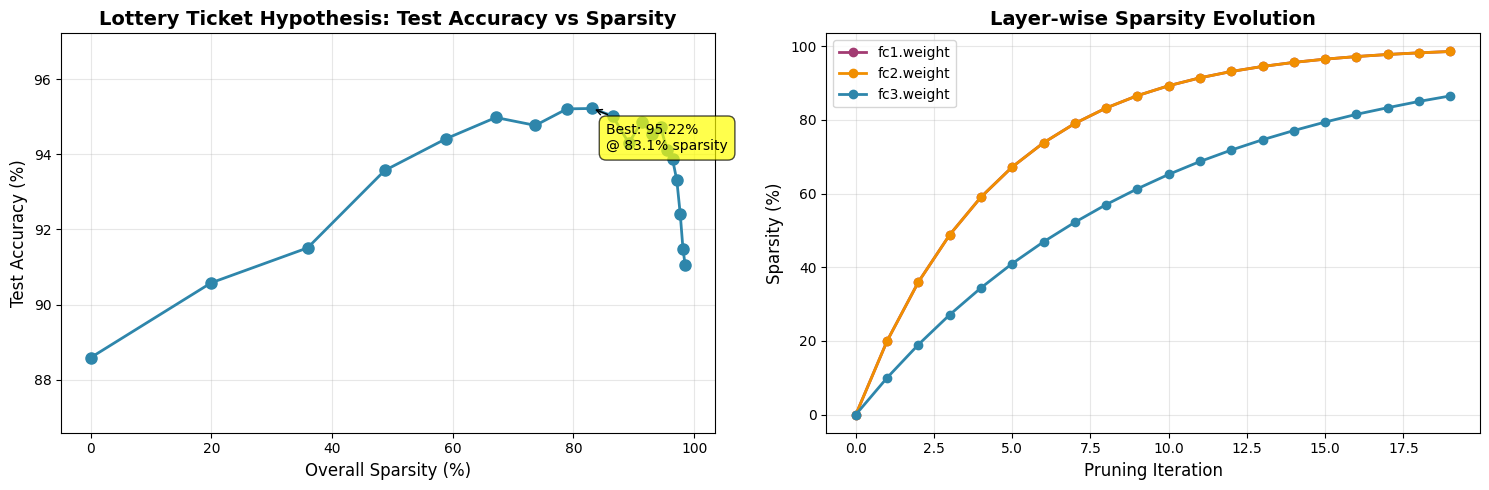


Summary Statistics:
Iteration    Sparsity     Test Acc    
------------------------------------
0            0.00       % 88.59      %
1            19.96      % 90.58      %
2            35.94      % 91.51      %
3            48.72      % 93.57      %
4            58.95      % 94.42      %
5            67.13      % 94.98      %
6            73.68      % 94.77      %
7            78.93      % 95.21      %
8            83.12      % 95.22      %
9            86.48      % 95.02      %
10           89.17      % 94.30      %
11           91.32      % 94.87      %
12           93.05      % 94.54      %
13           94.43      % 94.73      %
14           95.53      % 94.11      %
15           96.42      % 93.87      %
16           97.13      % 93.31      %
17           97.69      % 92.41      %
18           98.15      % 91.48      %
19           98.51      % 91.05      %


In [16]:
# Plot test accuracy vs sparsity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Test Accuracy vs Sparsity
sparsities = [s * 100 for s in results['overall_sparsity']]
accuracies = results['test_accuracy']

ax1.plot(sparsities, accuracies, 'o-', linewidth=2, markersize=8, color='#2E86AB')
ax1.set_xlabel('Overall Sparsity (%)', fontsize=12)
ax1.set_ylabel('Test Accuracy (%)', fontsize=12)
ax1.set_title('Lottery Ticket Hypothesis: Test Accuracy vs Sparsity', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([min(accuracies) - 2, max(accuracies) + 2])

# Annotate key points
max_acc_idx = accuracies.index(max(accuracies))
ax1.annotate(f'Best: {max(accuracies):.2f}%\n@ {sparsities[max_acc_idx]:.1f}% sparsity',
            xy=(sparsities[max_acc_idx], accuracies[max_acc_idx]),
            xytext=(10, -30), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Plot 2: Layer-wise Sparsity Evolution
ax2.set_xlabel('Pruning Iteration', fontsize=12)
ax2.set_ylabel('Sparsity (%)', fontsize=12)
ax2.set_title('Layer-wise Sparsity Evolution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

iterations = list(range(len(results['layer_sparsity'])))
layers = list(results['layer_sparsity'][0].keys())
colors = ['#A23B72', '#F18F01', '#2E86AB']

for i, layer in enumerate(layers):
    layer_sparsities = [results['layer_sparsity'][j][layer] * 100 
                        for j in range(len(results['layer_sparsity']))]
    ax2.plot(iterations, layer_sparsities, 'o-', linewidth=2, 
            markersize=6, label=layer, color=colors[i])

ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\nSummary Statistics:")
print(f"{'Iteration':<12} {'Sparsity':<12} {'Test Acc':<12}")
print("-" * 36)
for i in range(len(results['pruning_iteration'])):
    print(f"{i:<12} {sparsities[i]:<11.2f}% {accuracies[i]:<11.2f}%")